# Cliff Walking PyGame

![title](cliff_walking_pic.png)

# Load Packages

In [1]:
import gym
from gym import error, spaces, utils
import pygame
from io import StringIO
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

# Class Object 

In [2]:
class CliffWalkingEnv():
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        
        # Grid size
        self.grid_rows = 4
        self.grid_cols = 12

        # Locations
        self.start = [3, 0]
        self.goal = [3, 11]
        
        # Grid matrix
        self.grid = np.full((self.grid_rows, self.grid_cols), "-")
        self.grid[self.start[0],self.start[1]] = "S"
        self.grid[self.goal[0],self.goal[1]] = "G"

        # Action set 0=Up 1=Down 2=Left 3=Right
        self.actions = range(4)
        self.action_letters = ["Up","Down","Left","Right"]

        # Reward at Each Step
        self.reward = -1
        
        # Action space
        self.action_space =  spaces.Discrete(len(self.actions))
        
        # Observation space
        self.observation_space = spaces.Tuple((spaces.Discrete(self.grid_rows),
                                              spaces.Discrete(self.grid_cols)))
    
    # Initialize state location
    def reset(self):
        
        self.state = self.start
        return self.state
    
    # Function to move through environment
    def step(self, action):
        
        self.lasta = action
        rownum, colnum = self.state
        self.reward = -1
    
        # 0=Up
        if action==0:
            rownum = max( rownum -1, 0 )
    
        # 1=Down
        elif action==1:
            rownum = min( rownum +1, self.grid_rows-1 )
    
        # 2=Left
        elif action==2:
            colnum = max( colnum -1, 0 )
    
        # 3=Right
        else:
            colnum = min( colnum +1, self.grid_cols-1 )
        
        # Restart Position if Agent Moves Off Cliff
        if ( rownum==(self.grid_rows-1) ) & ( colnum in range(1,self.grid_cols-1) ):
            rownum = self.start[0]
            colnum = self.start[1]
            self.reward = -100
        
        # Update internal state location
        self.state = [rownum, colnum]
        
        # Indicator for episode end
        if self.state == self.goal:
            done = True
        else:
            done = False
            
        # Return new state, reward received, episode end indicator, additional information
        return self.state, self.reward, done, {}
       
    # Initialize Rendering
    def init_render(self):
        
        # Define Colors
        self.black = (0, 0, 0)
        self.white = (255, 255, 255)
        self.red = (255, 0, 0)
        self.green = (0, 255, 0)
        self.blue = (0, 0, 255)

        # Define Grid
        self.box_width = 40
        self.box_height = 40
        self.box_margin = 5

        # Initialize window
        pygame.init()
        self.window_size = [(self.box_width+self.box_margin)*self.grid_cols + self.box_margin, 
                            (self.box_height+self.box_margin)*self.grid_rows + self.box_margin+100]
        self.screen = pygame.display.set_mode(self.window_size)
        
        # Get Caption, Text, Images...
        pygame.display.set_caption("Cliff Walking")
        self.text_font = pygame.font.Font(None, 60)
        self.text_start = self.text_font.render('S', False, 'blue')
        self.text_goal = self.text_font.render('G', False, 'blue')
        self.eagle_image = pygame.image.load('hiker.png')
        
        # Initialize clock for fps
        self.clock = pygame.time.Clock()
        
    # Print the state of the agent in the environment
    def render(self, ep_num, step_num, mode="human"):
        
        # Render the screen
        self.screen.fill(self.black)
        self.text_episode = self.text_font.render('Episode '+str(ep_num), False, 'white')
        self.text_steps = self.text_font.render('Steps '+str(step_num), False, 'white')
        
        for row in range(self.grid_rows):
            for column in range(self.grid_cols):
            
                color = self.white
                if ( row==(self.grid_rows-1) ) & ( column in range(1,self.grid_cols-1) ):
                    color = self.red
                
                # Draw rectangles on screen for grid
                pygame.draw.rect(self.screen, color,
                                 [(self.box_margin + self.box_width) * column + self.box_margin, (self.box_margin + self.box_height) * row + self.box_margin,
                                  self.box_width, self.box_height])
        
        # Add Text, Images...
        self.screen.blit(self.text_start,((self.box_width+self.box_margin)*self.start[1] + self.box_margin+3, (self.box_height+self.box_margin)*self.start[0] + self.box_margin+3))
        self.screen.blit(self.text_goal,((self.box_width+self.box_margin)*self.goal[1] + self.box_margin+3, (self.box_height+self.box_margin)*self.goal[0] + self.box_margin+3))
        self.screen.blit(self.text_episode,((150, self.box_height* self.grid_rows + 30)))
        self.screen.blit(self.text_steps,((150, self.box_height* self.grid_rows + 80)))
        self.screen.blit(self.eagle_image,((self.box_margin + self.box_width) * self.state[1] + self.box_margin, (self.box_margin + self.box_height) * self.state[0] + self.box_margin))
    
        # Specify fps and update method
        self.clock.tick(10)
        pygame.display.update()

# Make Environment

In [3]:
env = CliffWalkingEnv()

# House Keeping

In [4]:
# Set a Seed
np.random.seed(802)

# Grid size
grid_rows = env.observation_space[0].n
grid_cols = env.observation_space[1].n

# Action set 0=Up 1=Down 2=Left 3=Right
actions = range(env.action_space.n)

# Step Size
alpha = 0.5

# Exploration Rate
epsilon = 0.1

# Set number of episodes to run
episodes = 150

# Q Table

In [5]:
q_table = np.zeros([grid_rows, grid_cols, len(actions)])

# Greedy Action Function

In [6]:
def greedy(state, q_table, epsilon):
    
    # Randomly select action with probability epsilon
    if np.random.uniform() < epsilon:
        g_action = np.random.choice(actions)
        
    # Select the best action for the given state with probability 1-epsilon
    else:
        q_vals = q_table[state[0], state[1], :]
        q_vals_max = np.where(q_vals==q_vals.max())[0]
        g_action = np.random.choice(q_vals_max)
    
    return g_action

# Q-Learning

In [7]:
# Store the steps to reach the goal for each episode
steps_vec = []

# Initialize Rendering
env.init_render()

# Q-Learning
for i in range(episodes):
    
    # Count steps per episode
    steps_count = 0
    
    # Always start in the same position
    state = env.reset()
    
    # Goal reached indicator to end episode
    episode_end = False
    
    # Loop until the goal is reached
    while episode_end != True:
        
        # PyGame
        for event in pygame.event.get(): 
            if event.type == pygame.QUIT: 
                episode_end = True
        
        # Choose action based on epsilon-greedy
        action = greedy(state, q_table, epsilon)
        
        # Find next state given current state and action
        new_state, reward, episode_end, info = env.step(action)
        
        # Update the q-table with Q-Learning
        q_table[state[0],state[1],action] =  q_table[state[0],state[1],action] + \
            alpha * ( reward + max(q_table[new_state[0],new_state[1],]) - \
            q_table[state[0],state[1],action] )

        # Set new state to current state
        state = new_state
        
        # Update steps count
        steps_count += 1
        
        # Render Agent
        if (i+1) % 10 == 0: 
            env.render(ep_num=i+1, step_num=steps_count)
            
            # Pause at goal state
            if episode_end == True:
                time.sleep(1)
        
    steps_vec.append(steps_count)
    
# Close Window
pygame.quit()

# View Results

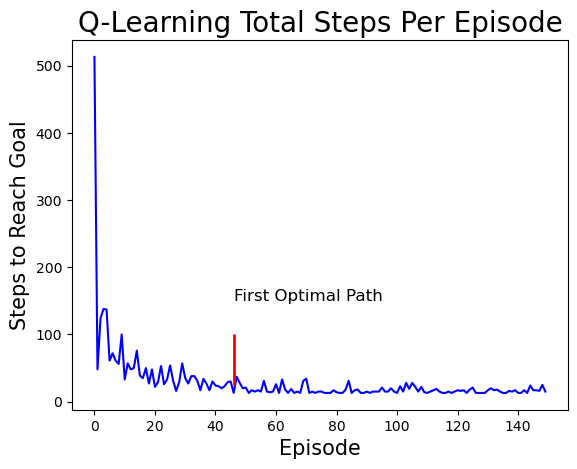

In [8]:
min_steps = min(steps_vec)
plt.plot(steps_vec, color="blue")
plt.title("Q-Learning Total Steps Per Episode", fontsize=20)
plt.xlabel("Episode", fontsize=15)
plt.ylabel("Steps to Reach Goal", fontsize=15)
plt.text(steps_vec.index(min_steps),150,"First Optimal Path", fontsize=12)
plt.vlines(x=steps_vec.index(min_steps), ymin=25, ymax=100, color='red', lw=2)
plt.show()

# Render Agent and Environment

In [9]:
# Initialize environment
state = env.reset()
grid = env.grid

episode_end = False
# View optimal agent path
while episode_end != True:
    
    # Use optimal action from q-table
    action = np.argmax(q_table[state[0],state[1],:])
    state, reward, episode_end, info = env.step(action)
    grid[state[0],state[1]] = "A"
    
grid

array([['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
       ['S', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'A']],
      dtype='<U1')